<a href="https://colab.research.google.com/github/Gangneng/pytorch_tutorial/blob/main/Training_a_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/KDT/파이토치_튜토리얼

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWivOigks7FOw6ycD-5SkVLFBIt1ZFiMfQH0VPdEeeAu3N9pRBpQF14


분류기를 훈련시켜보자.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

CIFAR 10 데이터를 불러오고, 정규화시켜보자.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


잘 불러와졌는지 사진을 확인해보자.

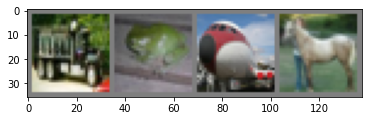

truck  frog plane horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

CNN 모델을 정의하여 보자.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

손실 함수 및 옵티마이저를 정의하여 보자.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

모델을 학습시켜보자.

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.191
[1,  4000] loss: 1.888
[1,  6000] loss: 1.684
[1,  8000] loss: 1.571
[1, 10000] loss: 1.524
[1, 12000] loss: 1.430
[2,  2000] loss: 1.385
[2,  4000] loss: 1.340
[2,  6000] loss: 1.340
[2,  8000] loss: 1.286
[2, 10000] loss: 1.302
[2, 12000] loss: 1.245
Finished Training


우리의 학습된 모델을 빠르게 저장하여 보자.

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

테스트 데이터를 활용하여 모델을 테스트해보자.

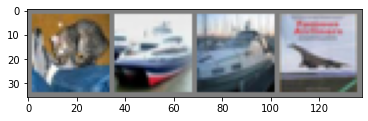

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

실제로 모델이 잘 예측을 했는지 확인해보자.

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


그렇게 좋은 성능을 보이는 것 같진 않다.... 50퍼센트만 맞았다. 차랑 배를 잘 구분하지 못하나보다.

전체 데이터에 대해서 성능을 어떻게 보이고 있는지 확인해보자.

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


각 클래스별로 어느 정도 정확성을 보이고 있는지 확인해보자.

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 60.6 %
Accuracy for class car   is: 71.8 %
Accuracy for class bird  is: 48.8 %
Accuracy for class cat   is: 32.0 %
Accuracy for class deer  is: 45.0 %
Accuracy for class dog   is: 55.0 %
Accuracy for class frog  is: 67.2 %
Accuracy for class horse is: 57.8 %
Accuracy for class ship  is: 72.8 %
Accuracy for class truck is: 63.5 %


생물들 특히 고양이는 32% 밖에 구별해내지 못하는 성능을 보이고 있다...

아무튼, 이와 같은 모델을 GPU를 이용해 학습시키려면 다음과 같이 GPU를 사용한다고 선언해주어야 한다.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


GPU를 사용하기 위해선 모델도, 데이터도 전부 CUDA 텐서로 변환해야 한다.

In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
inputs, labels = data[0].to(device), data[1].to(device)